In [1]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

Using TensorFlow backend.


In [3]:
base_path = '/mnt/sda1/celeba-dataset/processed'

x_train_list = sorted(glob.glob(os.path.join(base_path, 'x_train', '*.npy')))
x_val_list = sorted(glob.glob(os.path.join(base_path, 'x_val', '*.npy')))

print(len(x_train_list), len(x_val_list))
print(x_train_list[0])

162770 19867
/mnt/sda1/celeba-dataset/processed/x_train/000001.npy


(44, 44, 3) (44, 44, 3)


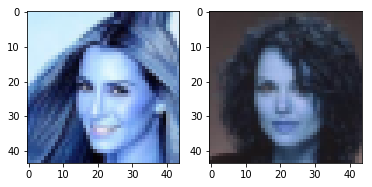

In [4]:
x1 = np.load(x_train_list[0])
x2 = np.load(x_val_list[0])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

In [5]:
train_gen = DataGenerator(list_IDs=x_train_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=True)

val_gen = DataGenerator(list_IDs=x_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)

In [6]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel_1 (Subpixel)        (None, 176, 176, 3)       6960      
_________________________________________________________________
activation_1 (Activation)    (None, 176, 176, 3)       0         
Total para

In [7]:
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=10, verbose=1, callbacks=[
    ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True)
])

Epoch 1/10
10173/10173 [==============================] - 4635s 456ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 00001: val_loss improved from inf to 0.00177, saving model to models/model.h5
Epoch 2/10
10173/10173 [==============================] - 4449s 437ms/step - loss: 0.0015 - val_loss: 0.0014

Epoch 00002: val_loss improved from 0.00177 to 0.00138, saving model to models/model.h5
Epoch 3/10
10173/10173 [==============================] - 4438s 436ms/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00003: val_loss improved from 0.00138 to 0.00134, saving model to models/model.h5
Epoch 4/10
10173/10173 [==============================] - 4447s 437ms/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00004: val_loss improved from 0.00134 to 0.00133, saving model to models/model.h5
Epoch 5/10
10173/10173 [==============================] - 4444s 437ms/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00005: val_loss improved from 0.00133 to 0.00133, saving model to models/model.h5
Epoch 6/10
101

In [5]:
x_test_list = sorted(glob.glob(os.path.join(base_path, 'x_test', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path, 'y_test', '*.npy')))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

NameError: name 'base_path' is not defined

In [4]:
test_idx = 21

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)

OSError: Failed to interpret file 'img/81730.jpg' as a pickle